<a href="https://colab.research.google.com/github/Jiyun2025/Who-are-you/blob/main/famous_restaurant_yelp_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [1]:
import pandas as pd

# Import sqlite3 for python
import sqlite3

# Connect to the database. It's in a file called web_requests.db.
conn = sqlite3.connect('web_requests.db')

# Count the number of rows
print(conn.execute('SELECT COUNT(*) FROM web_logs').fetchall())
print(conn.execute('SELECT COUNT(*) FROM web_logs').fetchone())

OperationalError: no such table: web_logs

## UDF Exploration

In [ ]:
# define the udf : extract the last part of the URL after the last slash

def extract_last_part(url):
  return url.split('/')[-1]

#Test with the a few examples with print outs
print(extract_last_part('/'))

#Register the UDF with sqlite3
conn.create_function('get_product',1,extract_last_part)

In [ ]:
sql = """
  SELECT
  COUNT(DISTINCT ip_address) AS unique_ips,
  get_product(requested_page) AS product

  FROM
    web_logs

  WHERE product<>''

  GROUP BY
    product
  ORDER BY
    unique_ips DESC;

"""
pd.read_spl(sql,conn)


# Exploration

In [ ]:
# Calculate the runtime for the following operation
import time
start = time.time()
pd.DataFrame(conn.execute('SELECT * FROM web_logs LIMIT 1').fetchall())
print('Time taken: ', time.time() - start)

Time taken:  0.0054361820220947266


In [ ]:
# Calculate the runtime for the following operation
import time
start = time.time()
pd.DataFrame(conn.execute('SELECT * FROM web_logs').fetchone()[0:5])
print('Time taken: ', time.time() - start)

Time taken:  0.0009808540344238281


In [ ]:
# Get top five rows that correspond to timestamps from 8 days ago
import datetime
eight_days_ago = datetime.datetime.now() - datetime.timedelta(days=8)
# COnvert to unix time
eight_days_ago_unix = eight_days_ago.timestamp()

ten_days_ago = datetime.datetime.now() - datetime.timedelta(days=10)
# COnvert to unix time
ten_days_ago_unix = ten_days_ago.timestamp()

# DONT DO THE FOLLOWING
# pd.DataFrame(conn.execute(f'SELECT * FROM web_logs WHERE unix_timestamp > {eight_days_ago_unix} LIMIT 5').fetchall())

# Get the top 5 rows, using pandas read_sql statement
pd.read_sql('SELECT * FROM web_logs WHERE unix_timestamp < ? AND unix_timestamp > ? LIMIT 5', conn, params=(eight_days_ago_unix, ten_days_ago_unix))


,ip_address,unix_timestamp,requested_page


In [ ]:
# Print out the first 5 rows in a pandas dataframe without the cursor object
df = pd.read_sql('SELECT * FROM web_logs LIMIT 5', conn)
df

,ip_address,unix_timestamp,requested_page
0,67.21.186.204,1724976113,/backend_api/get_product_name/2102cfe7-117f-4a...
1,67.21.186.204,1724976114,/backend_api/get_product_name/2102cfe7-117f-4a...
2,67.21.186.204,1724976114,/backend_api/get_product_name/2102cfe7-117f-4a...
3,67.21.186.204,1724976115,/backend_api/get_product_name/2102cfe7-117f-4a...
4,67.21.186.204,1724976115,/backend_api/get_product_name/2102cfe7-117f-4a...


# Analysis

## Who is visiting

In [ ]:
conn.execute('SELECT COUNT(DISTINCT ip_address) AS unique_visitor_count FROM web_logs;').fetchall()

[(3200,)]

In [ ]:
# SQL query that counts the number of unique IP addresses
query = """

    SELECT COUNT(DISTINCT ip_address) AS unique_visitor_count FROM web_logs;

"""

# Output the result of the query as a pandas dataframe
pd.read_sql(query, conn)

,unique_visitor_count
0,3200


## When they are visiting

In [ ]:
pd.read_sql("""
    SELECT
            ip_address,
            unix_timestamp,
            DATE(unix_timestamp, 'unixepoch') AS date,
            strftime('%w', unix_timestamp, 'unixepoch') AS day_of_week
    FROM web_logs
""", conn)

,ip_address,unix_timestamp,date,day_of_week
0,130.127.49.251,1724889602,2024-08-29,4
1,130.127.49.251,1724889603,2024-08-29,4
2,130.127.49.251,1724889603,2024-08-29,4
3,130.127.49.251,1724889603,2024-08-29,4
4,130.127.49.251,1724889608,2024-08-29,4
...,...,...,...,...
340147,207.231.111.167,1726097535,2024-09-11,3
340148,207.231.111.167,1726097625,2024-09-11,3
340149,66.249.77.162,1726097829,2024-09-11,3
340150,66.249.77.164,1726097830,2024-09-11,3


In [ ]:
sql = """
    EXPLAIN QUERY PLAN
    SELECT
            ip_address,
            unix_timestamp,
            DATE(unix_timestamp, 'unixepoch') AS date
    FROM web_logs
    WHERE date = '2024-09-02'
    LIMIT 5
"""
conn.execute(sql).fetchall()

[(3, 0, 0, 'SCAN web_logs USING COVERING INDEX ts_ip_idx')]

In [ ]:
import time

In [ ]:
pd.read_sql('select rowid, * from web_logs limit 10;', conn)

,rowid,ip_address,unix_timestamp,requested_page
0,1,67.21.186.204,1724976113,/backend_api/get_product_name/2102cfe7-117f-4a...
1,2,67.21.186.204,1724976114,/backend_api/get_product_name/2102cfe7-117f-4a...
2,3,67.21.186.204,1724976114,/backend_api/get_product_name/2102cfe7-117f-4a...
3,4,67.21.186.204,1724976115,/backend_api/get_product_name/2102cfe7-117f-4a...
4,5,67.21.186.204,1724976115,/backend_api/get_product_name/2102cfe7-117f-4a...
5,6,67.21.186.204,1724976116,/backend_api/get_product_name/2102cfe7-117f-4a...
6,7,67.21.186.204,1724976116,/backend_api/get_product_name/2102cfe7-117f-4a...
7,8,67.21.186.204,1724976117,/backend_api/get_product_name/2102cfe7-117f-4a...
8,9,67.21.186.204,1724976117,/backend_api/get_product_name/2102cfe7-117f-4a...
9,10,67.21.186.204,1724976117,/backend_api/get_product_name/2102cfe7-117f-4a...


In [ ]:
conn.execute("""
    CREATE VIEW v AS
    SELECT
            ip_address,
            COUNT(DISTINCT unix_timestamp) AS ct
    FROM web_logs
    GROUP BY ip_address
    ORDER BY ct DESC
    LIMIT 10
""");

In [ ]:
pd.read_sql('select * from v;', conn)

,ip_address,ct
0,24.33.229.204,40368
1,130.127.49.251,18687
2,72.205.125.88,9650
3,92.40.168.143,4432
4,128.122.76.33,2733
5,223.123.89.122,2554
6,92.40.168.144,2503
7,174.106.118.17,1857
8,92.40.168.231,1520
9,92.40.168.145,1517


In [ ]:
sql = """
    SELECT
        DISTINCT requested_page
    FROM web_logs
    JOIN v ON (web_logs.ip_address = v.ip_address)
    ;

"""
pd.read_sql(sql, conn)

,requested_page
0,/site/post/getting-started/
1,/site/webfonts/source-code-pro/main.css
2,/site/webfonts/ptserif/main.css
3,/site/css/style.css
4,/favicon.ico
...,...
3661,/backend_api/get_hostname_from_ip/1498aaab-2f8...
3662,/backend_api/get_hostname_from_ip/1498aaab-2f8...
3663,/backend_api/get_hostname_from_ip/1498aaab-2f8...
3664,/backend_api/get_hostname_from_ip/1498aaab-2f8...


In [ ]:
conn.execute(f'EXPLAIN QUERY PLAN {sql}').fetchall()


[(8, 0, 0, 'SCAN t'),
 (10, 0, 0, 'SEARCH web_logs USING INDEX ip_address_ix (ip_address=?)'),
 (16, 0, 0, 'USE TEMP B-TREE FOR GROUP BY')]

In [ ]:
conn.execute(f'EXPLAIN QUERY PLAN {sql}').fetchall()


[(2, 0, 0, 'CO-ROUTINE v'),
 (11, 2, 0, 'SCAN web_logs USING INDEX ip_address_ix'),
 (49, 2, 0, 'USE TEMP B-TREE FOR count(DISTINCT)'),
 (52, 2, 0, 'USE TEMP B-TREE FOR ORDER BY'),
 (65, 0, 0, 'SCAN v'),
 (68, 0, 0, 'SEARCH web_logs USING INDEX ip_address_ix (ip_address=?)'),
 (74, 0, 0, 'USE TEMP B-TREE FOR GROUP BY')]

In [ ]:
sql = """
SELECT
    requested_page
FROM web_logs
JOIN (
    SELECT
        ip_address,
        COUNT(DISTINCT unix_timestamp) AS ct
    FROM web_logs
    GROUP BY ip_address
    ORDER BY ct DESC
    LIMIT 10
) AS subquery ON web_logs.ip_address = subquery.ip_address
GROUP BY requested_page;
"""
conn.execute(f'EXPLAIN QUERY PLAN {sql}').fetchall()

[(2, 0, 0, 'CO-ROUTINE subquery'),
 (11, 2, 0, 'SCAN web_logs USING INDEX ip_address_ix'),
 (49, 2, 0, 'USE TEMP B-TREE FOR count(DISTINCT)'),
 (52, 2, 0, 'USE TEMP B-TREE FOR ORDER BY'),
 (65, 0, 0, 'SCAN subquery'),
 (68, 0, 0, 'SEARCH web_logs USING INDEX ip_address_ix (ip_address=?)'),
 (74, 0, 0, 'USE TEMP B-TREE FOR GROUP BY')]

In [ ]:
# Count the number of unique IP addresses that visited the website on each day
start_ts = time.time()
for _ in range(10):
    df = pd.read_sql("""
        SELECT
                strftime('%w', unix_timestamp, 'unixepoch') AS day_of_week,
                COUNT(DISTINCT ip_address) AS unique_visitors
        FROM web_logs
        GROUP BY day_of_week
        ORDER BY unique_visitors DESC
    """, conn)
end_ts = time.time()
print(end_ts - start_ts)
df

5.142711639404297


,day_of_week,unique_visitors
0,3,707
1,5,670
2,2,655
3,4,646
4,6,567
5,1,560
6,0,507


In [ ]:
conn.execute("""
EXPLAIN QUERY PLAN
        SELECT
                strftime('%w', unix_timestamp, 'unixepoch') AS day_of_week,
                COUNT(DISTINCT ip_address) AS unique_visitors
        FROM web_logs
        GROUP BY day_of_week
        ORDER BY unique_visitors DESC;
             """).fetchall()


[(7, 0, 0, 'SCAN web_logs USING COVERING INDEX ts_ip_idx'),
 (9, 0, 0, 'USE TEMP B-TREE FOR GROUP BY'),
 (51, 0, 0, 'USE TEMP B-TREE FOR count(DISTINCT)'),
 (54, 0, 0, 'USE TEMP B-TREE FOR ORDER BY')]

In [ ]:
# Create an index on the ip_address column
conn.execute('CREATE INDEX ts_ip_idx ON web_logs(unix_timestamp, ip_address);')

OperationalError: index ts_ip_idx already exists

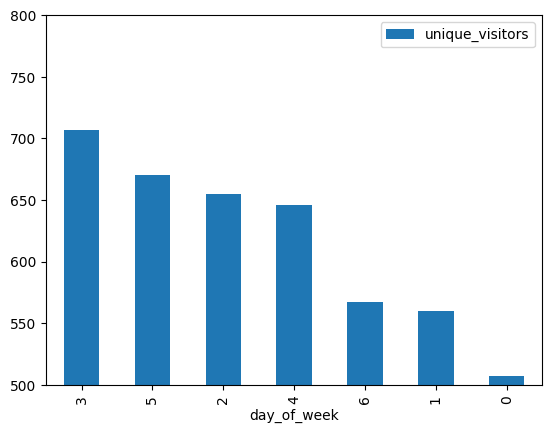

In [ ]:
# make a bar chart out of df, which shows number of visitors per day of the week
import matplotlib.pyplot as plt


df.plot(kind='bar', x='day_of_week', y='unique_visitors')

# Restrict the y axis range to 500 - 800
plt.ylim(500, 800)

plt.show()


In [ ]:
sql = """
    EXPLAIN QUERY PLAN
    SELECT
            DATE(unix_timestamp, 'unixepoch') AS date,
            COUNT(DISTINCT ip_address) AS unique_visitors
    FROM web_logs
    GROUP BY date
    HAVING unique_visitors > 300
    ORDER BY unique_visitors DESC
"""
conn.execute(sql).fetchall()

[(7, 0, 0, 'SCAN web_logs'),
 (9, 0, 0, 'USE TEMP B-TREE FOR GROUP BY'),
 (52, 0, 0, 'USE TEMP B-TREE FOR count(DISTINCT)'),
 (55, 0, 0, 'USE TEMP B-TREE FOR ORDER BY')]

## What they are doing on the site

# Visualization